In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

from src.parameters import (ANIMALS, SAMPLING_FREQUENCY)

In [3]:
epoch_key = ('HPa', 6, 2)

In [5]:
from loren_frank_data_processing.position import get_position_dataframe

In [6]:
position_info = get_position_dataframe(epoch_key, ANIMALS)
position_info.head()

,x_position,y_position,head_direction,speed
time,,,,
01:08:43.045500,NaN,NaN,NaN,NaN
01:08:43.078800,NaN,NaN,NaN,NaN
01:08:43.112200,86.45,97.50,2.654693,28.920020
01:08:43.145500,85.80,96.85,2.723368,28.920020
01:08:43.178900,85.80,96.20,2.770701,28.834258


In [7]:
from loren_frank_data_processing.core import get_data_structure
import networkx as nx

def get_track_segments(epoch_key, animals):
    '''
    Parameters
    ----------
    epoch_key : tuple
    animals : dict of namedtuples
    
    Returns
    -------
    track_segments : ndarray, shape (n_segments, n_nodes, n_space)

    '''
    animal, day, epoch = epoch_key
    task_file = get_data_structure(animals[animal], day, 'task', 'task')
    linearcoord = task_file[epoch - 1]['linearcoord'][0, 0].squeeze()
    d = [np.stack(((arm[:-1, :, 0], arm[1:, :, 0])), axis=1)
         for arm in linearcoord]
    return np.unique(np.concatenate(d), axis=0)

track_segments = get_track_segments(epoch_key, ANIMALS)
nodes = np.unique(track_segments.reshape((-1, 2)), axis=0)

edges = np.zeros(track_segments.shape[:2], dtype=int)
for node_id, node in enumerate(nodes):
    edges[np.isin(track_segments, node).sum(axis=2) > 0] = node_id

edge_distances = np.linalg.norm(np.diff(track_segments, axis=-2).squeeze(), axis=1)    

G = nx.Graph()

for node_id, node_position in enumerate(nodes):
    G.add_node(node_id, pos=tuple(node_position))
    
for edge, distance in zip(edges, edge_distances):
    G.add_edge(edge[0], edge[1], distance=distance)
    
track_segments

array([[[  62.81105991,   24.03508772],
        [  64.74654378,   99.47368421]],

       [[  96.8202765 ,  100.87719298],
        [  98.47926267,   25.0877193 ]],

       [[  98.47926267,   25.0877193 ],
        [  62.81105991,   24.03508772]],

       [[  98.47926267,   25.0877193 ],
        [ 131.10599078,   24.73684211]],

       [[ 131.10599078,   24.73684211],
        [ 129.44700461,  101.22807018]]])

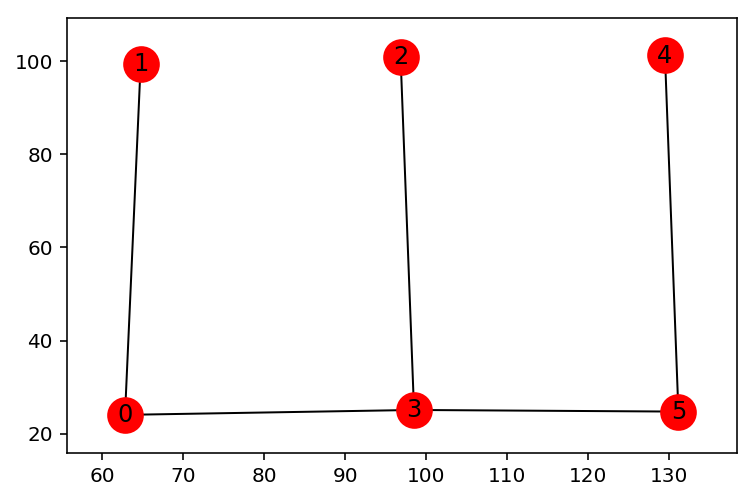

In [905]:
node_pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, node_pos, ax=None)

## Naive Method

Find nearest segment

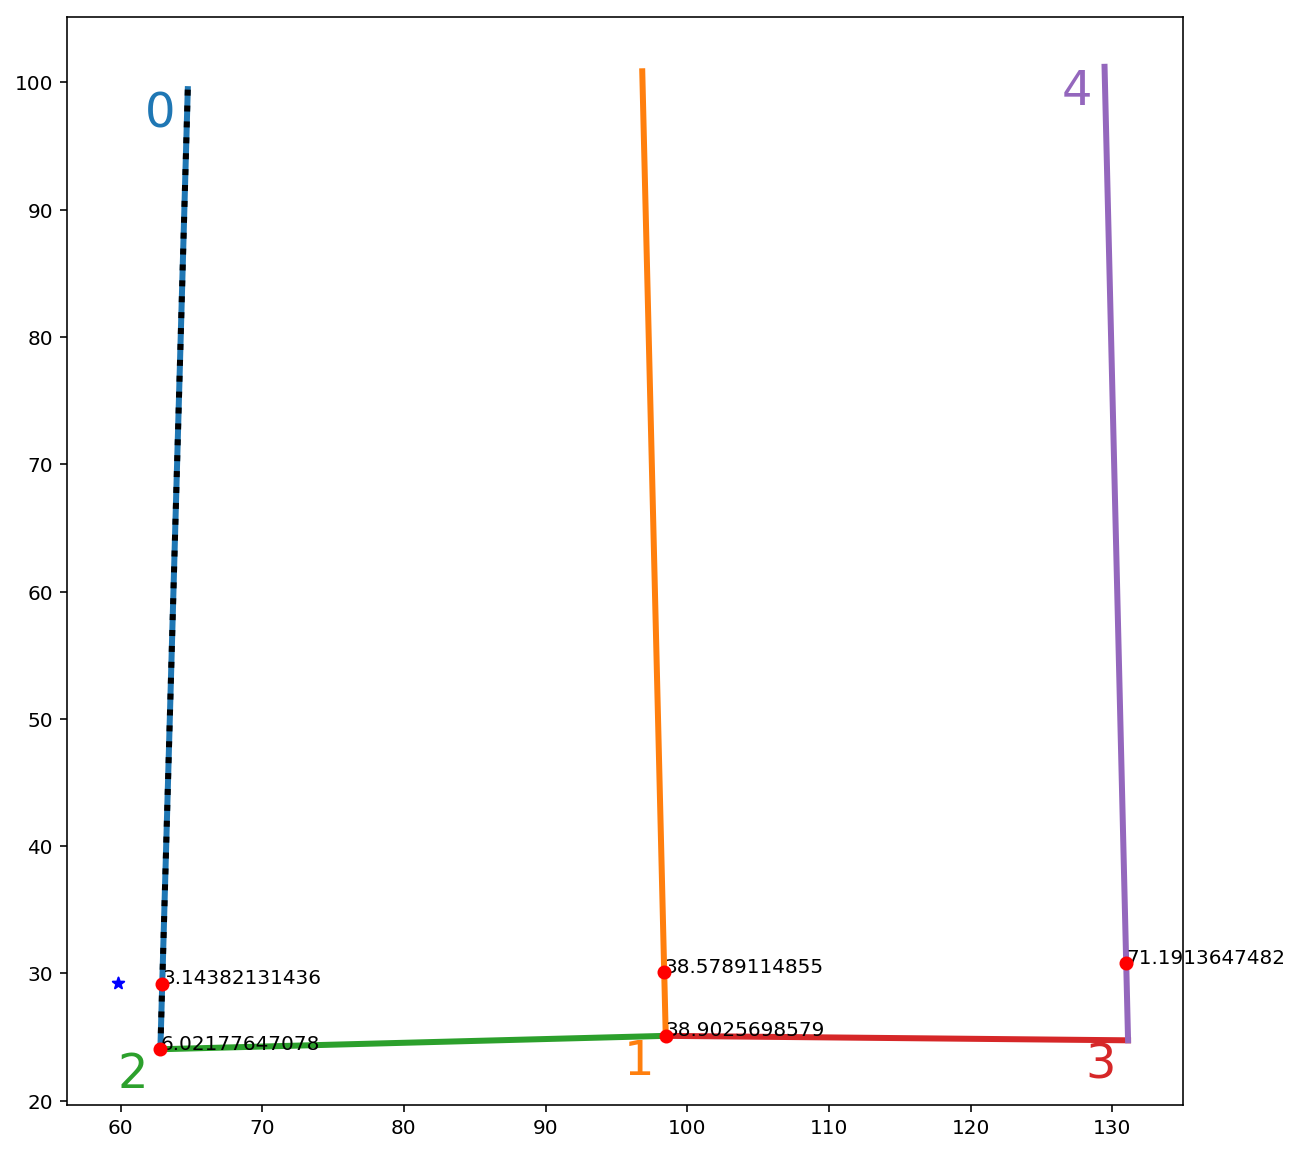

In [9]:
ind = 2000
point = position_info.iloc[ind].x_position, position_info.iloc[ind].y_position
x_point, y_point = point

def project_point(segment, point):
    (x1, y1), (x2, y2) = segment
    x_point, y_point = point
    dx = x2 - x1
    dy = y2 - y1
    d2 = dx ** 2 + dy ** 2
    nx = ((x_point - x1) * dx + (y_point - y1) * dy) / d2
    nx = min(1, max(0, nx))
    return np.array((x1 + nx * dx, y1 + nx * dy))

plt.figure(figsize=(10, 10))
plt.scatter(x_point, y_point, marker='*', color='blue')

for segment_number, segment in enumerate(track_segments):
    x, y = project_point(segment, point)
    (x1, y1), (x2, y2) = segment
    l = plt.plot([x1, x2], [y1, y2], linewidth=3)
    plt.scatter(x, y, color='red', zorder=100)
    distance = np.linalg.norm(point - project_point(segment, point))
    plt.text(x, y, distance)
    plt.text(x2 - 3, y2 - 3, segment_number, color=l[0].get_color(), fontsize=24)
    
def find_nearest_segment(point, track_segments):
    distance = [np.linalg.norm(point - project_point(segment, point))
                for segment in track_segments]
    return np.argmin(distance)

closest_segment_ind = find_nearest_segment(point, track_segments)

(x1, y1), (x2, y2) = track_segments[closest_segment_ind]
plt.plot([x1, x2], [y1, y2], linestyle=':', linewidth=3, color='black')

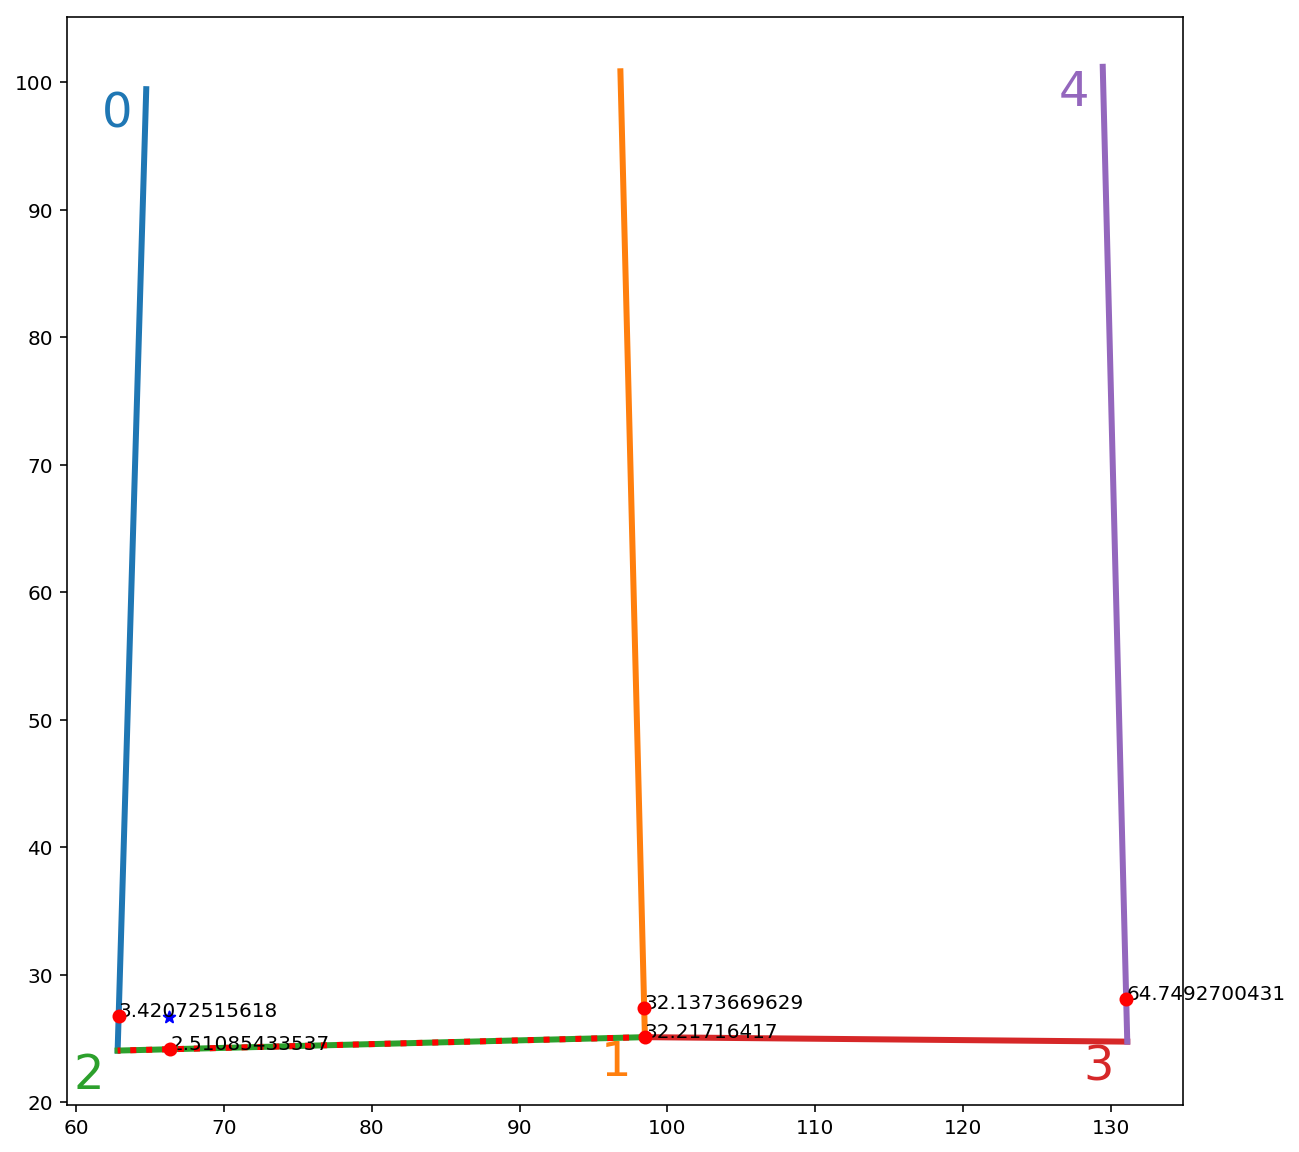

In [10]:
ind = 1990
point = position_info.iloc[ind].x_position, position_info.iloc[ind].y_position
x_point, y_point = point

plt.figure(figsize=(10, 10))
plt.scatter(x_point, y_point, marker='*', color='blue')

for segment_number, segment in enumerate(track_segments):
    x, y = project_point(segment, point)
    (x1, y1), (x2, y2) = segment
    l = plt.plot([x1, x2], [y1, y2], linewidth=3)
    plt.scatter(x, y, color='red', zorder=100)
    distance = np.linalg.norm(point - project_point(segment, point))
    plt.text(x, y, distance)
    plt.text(x2 - 3, y2 - 3, segment_number, color=l[0].get_color(), fontsize=24)

closest_segment_ind = find_nearest_segment(point, track_segments)

(x1, y1), (x2, y2) = track_segments[closest_segment_ind]
plt.plot([x1, x2], [y1, y2], linestyle=':', linewidth=3, color='red')

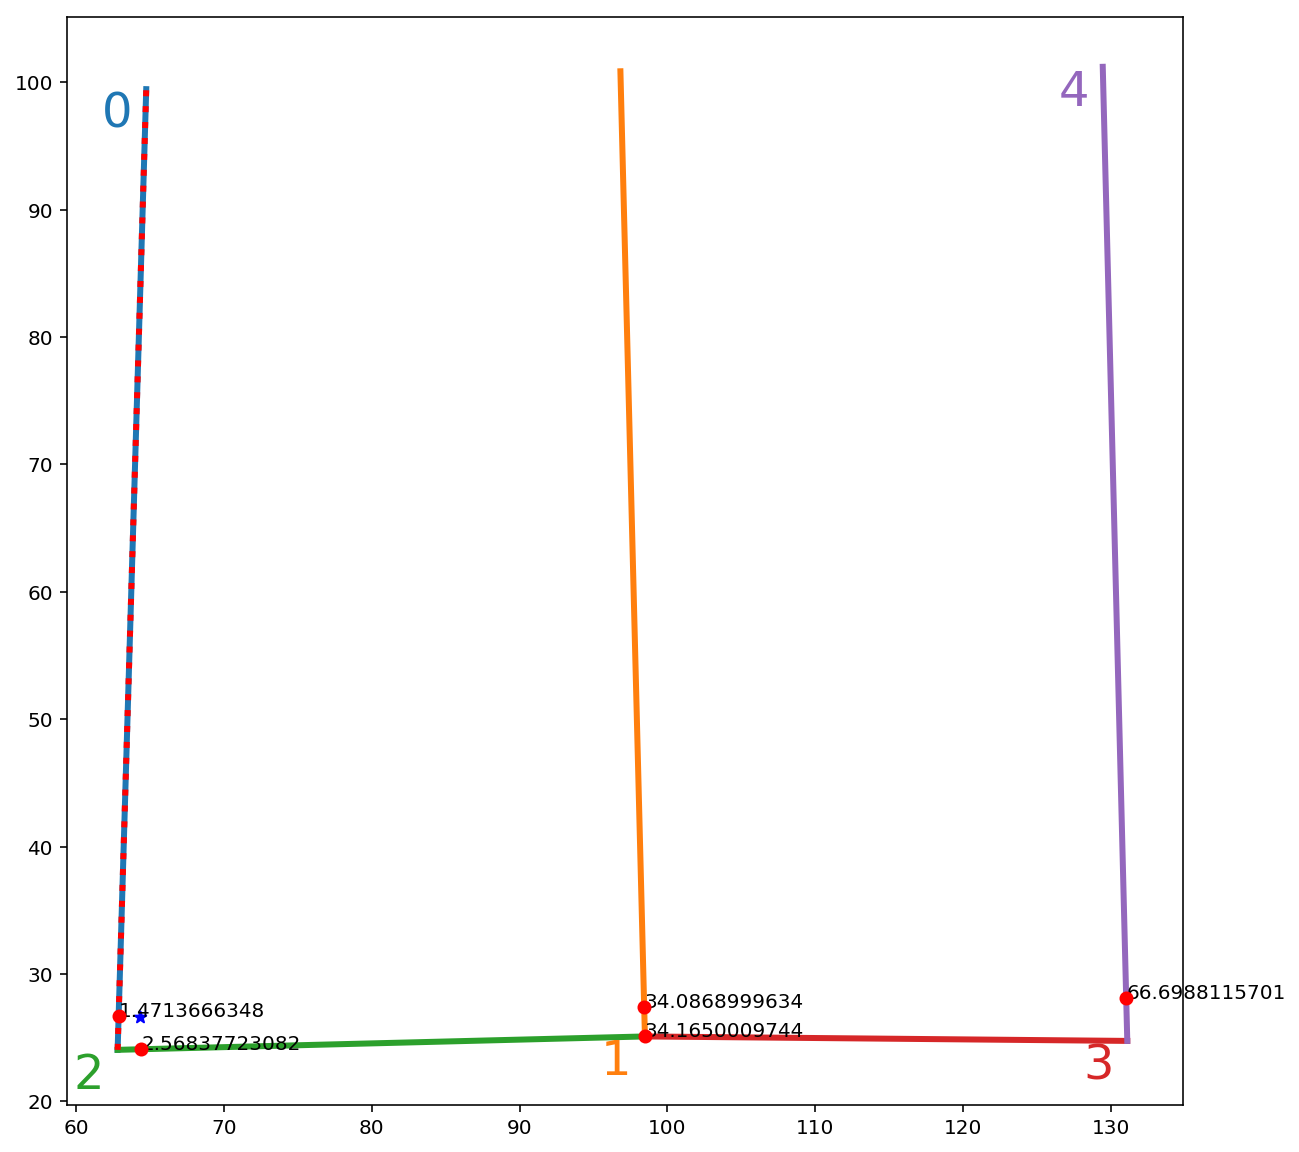

In [10]:
ind = 1992
point = position_info.iloc[ind].x_position, position_info.iloc[ind].y_position
x_point, y_point = point

plt.figure(figsize=(10, 10))
plt.scatter(x_point, y_point, marker='*', color='blue')

for segment_number, segment in enumerate(track_segments):
    x, y = project_point(segment, point)
    (x1, y1), (x2, y2) = segment
    l = plt.plot([x1, x2], [y1, y2], linewidth=3)
    plt.scatter(x, y, color='red', zorder=100)
    distance = np.linalg.norm(point - project_point(segment, point))
    plt.text(x, y, distance)
    plt.text(x2 - 3, y2 - 3, segment_number, color=l[0].get_color(), fontsize=24)

closest_segment_ind = find_nearest_segment(point, track_segments)

(x1, y1), (x2, y2) = track_segments[closest_segment_ind]
plt.plot([x1, x2], [y1, y2], linestyle=':', linewidth=3, color='red')

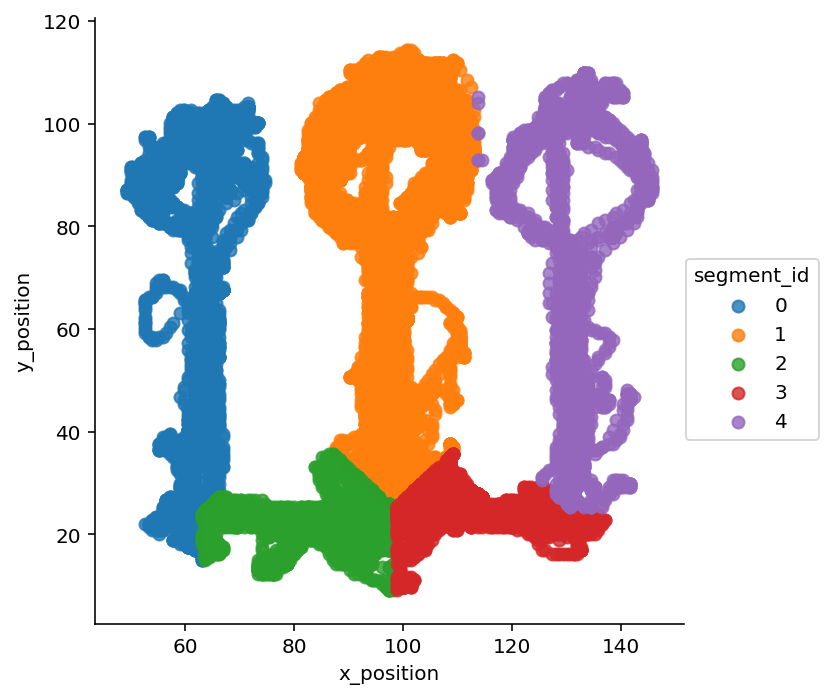

In [11]:
xy = position_info.loc[:, ['x_position', 'y_position']].values
naive_position_info = position_info.copy()
naive_position_info['segment_id'] = np.apply_along_axis(find_nearest_segment, 1, xy, track_segments)
sns.lmplot('x_position', 'y_position', data=naive_position_info, hue='segment_id', fit_reg=False)

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


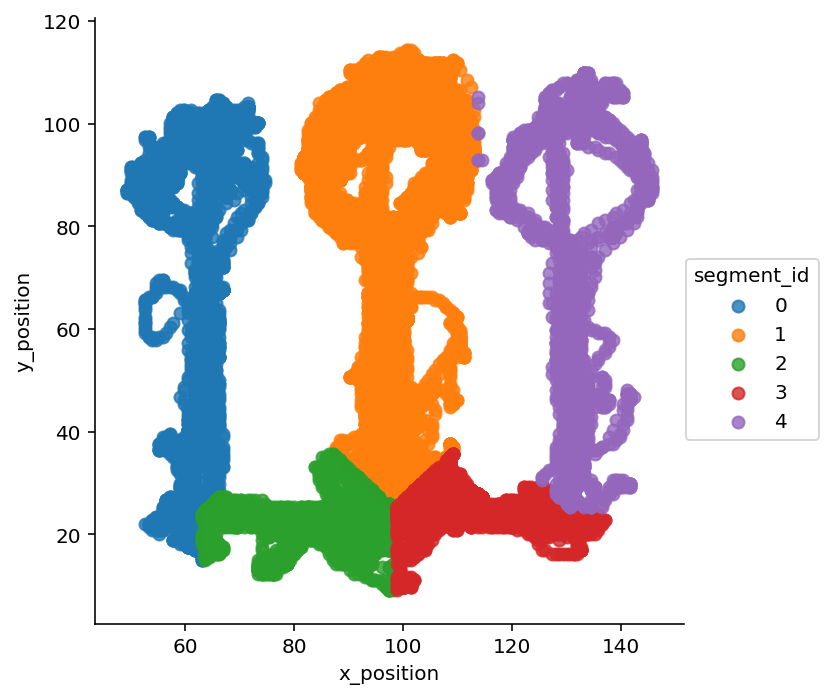

In [12]:
def project_point(segment, point):
    (x1, y1), (x2, y2) = segment
    x_point, y_point = point
    dx = x2 - x1
    dy = y2 - y1
    d2 = dx ** 2 + dy ** 2
    nx = ((x_point - x1) * dx + (y_point - y1) * dy) / d2
    nx = min(1, max(0, nx))
    return np.array((x1 + nx * dx, y1 + nx * dy))

def project_point2(segments, points):
    segment_diff = np.diff(segments, axis=1).squeeze()
    sum_squares = np.sum(segment_diff ** 2, axis=1)
    node1 = segments[:, 0, :]
    nx = (np.sum(segment_diff * (points[:, np.newaxis, :] - node1), axis=2) /
          sum_squares)
    nx[np.where(nx < 0)] = 0.0
    nx[np.where(nx > 1)] = 1.0
    return node1[np.newaxis, ...] + (nx[:, :, np.newaxis] * segment_diff[np.newaxis, ...])


def find_projected_point_distance(segments, points):
    return np.linalg.norm(points[:, np.newaxis, :] -
                          project_point2(segments, points), axis=2)


def find_nearest_segment2(segments, points):
    distance = find_projected_point_distance(segments, points)
    return np.argmin(distance, axis=1)

xy = position_info.loc[:, ['x_position', 'y_position']].values
naive_position_info2 = position_info.copy()
naive_position_info2['segment_id'] = find_nearest_segment2(track_segments, xy)
sns.lmplot('x_position', 'y_position', data=naive_position_info2, hue='segment_id', fit_reg=False)

segment_id = naive_position_info2.segment_id.values
projected_points = project_point2(track_segments, xy)

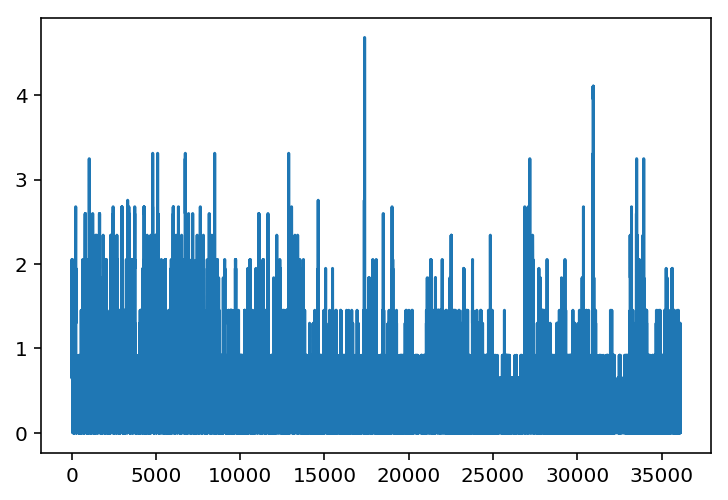

In [13]:
def point_distance(points):
    distance = np.linalg.norm(points[1:] - points[:-1], axis=1)
    return np.concatenate(([np.nan], distance))

plt.plot(point_distance(xy))

,b0,b1,b2,b3,b4
a0,0.649786,180.437036,98.488301,109.064310,214.121673
a1,180.437094,0.649844,82.598579,72.022570,177.079932
a2,97.857689,81.929560,0.019174,10.556835,115.614197
a3,108.414524,71.372725,10.576009,0.000000,105.057362
a4,214.121734,177.079935,116.283219,105.707209,0.649847


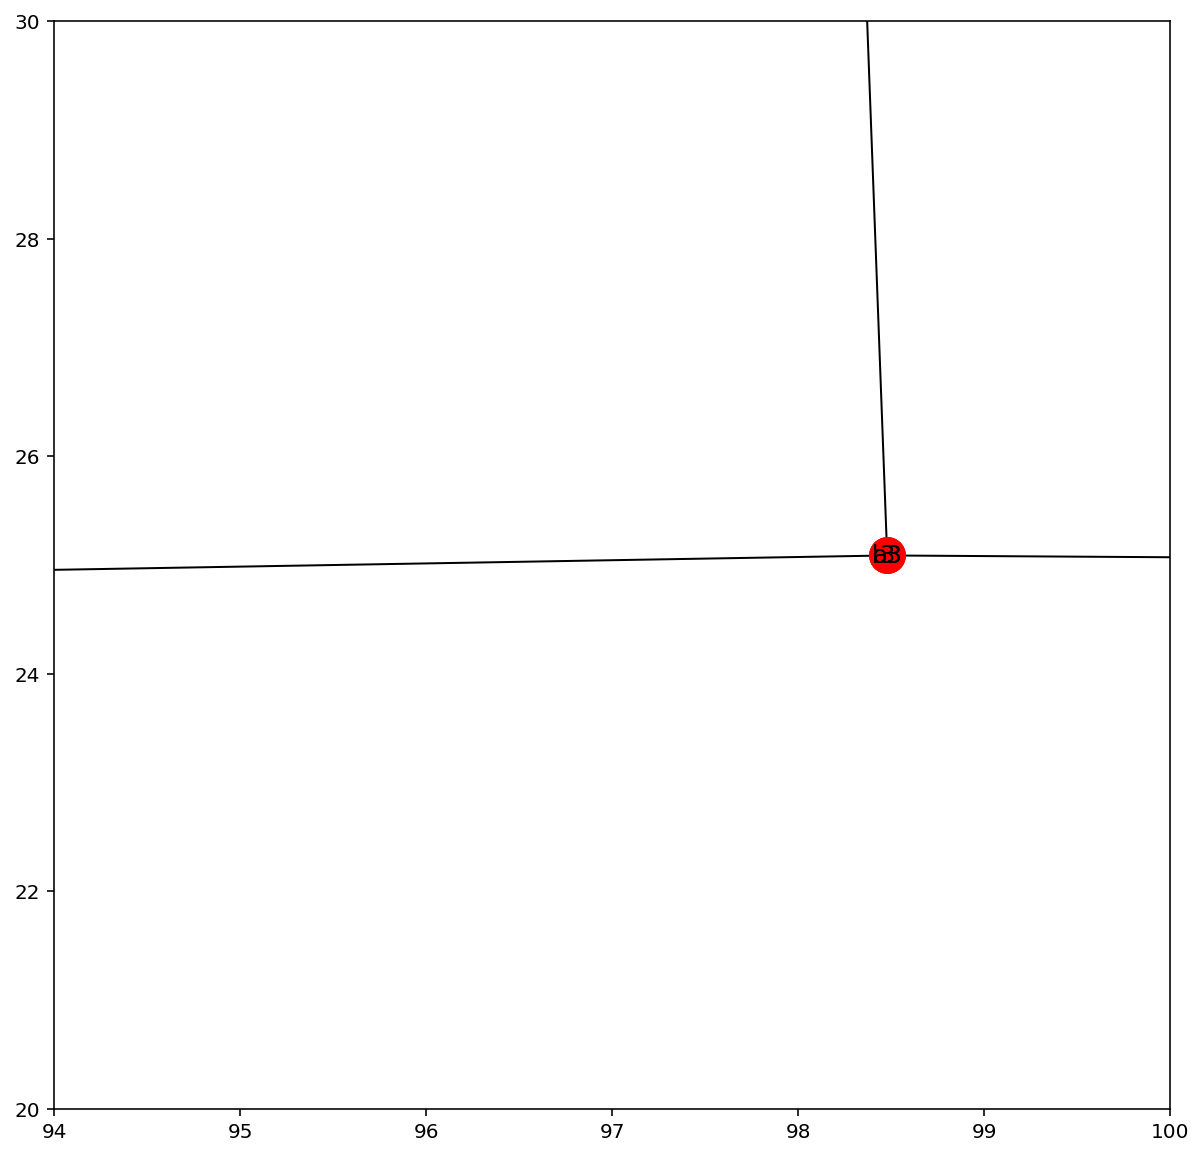

In [780]:
from itertools import product

candidates_t_1 = projected_points[4]
candidates_t = projected_points[3]
G1 = G.copy()

## insert virtual node (or existing node)
for candidate_id, (position_t, position_t_1, edge_id) in enumerate(zip(candidates_t, candidates_t_1, edges)):
    node_name_t = 'a{0}'.format(candidate_id) 
    node_name_t_1 = 'b{0}'.format(candidate_id)
    node1, node2 = edge_id
    outside_nodes = np.array([node1, node2], dtype=object)
    inside_nodes = np.array([node_name_t, node_name_t_1], dtype=object)
    outside_pos = np.array([G1.nodes[node1]['pos'], G1.nodes[node2]['pos']])
    inside_pos = np.array([position_t, position_t_1])
    sorted_outside = np.argsort(outside_pos, axis=0)[:, 0]
    sorted_inside = np.argsort(inside_pos, axis=0)[:, 0]
    nodes = np.empty((4,), dtype=object)
    nodes[[1, 2]] = inside_nodes[sorted_inside]
    nodes[[0, 3]] = outside_nodes[sorted_outside]
    G1.add_path(nodes)
    G1.remove_edge(node1, node2)
    G1.nodes[node_name_t]['pos'] = tuple(position_t)
    G1.nodes[node_name_t_1]['pos'] = tuple(position_t_1)

## calculate distance
for e in G1.edges(data=True):
    G1.edges[e[:2]]['distance'] = np.linalg.norm(
        G1.node[e[0]]['pos'] -
        np.array(G1.node[e[1]]['pos']))

## calculate path distance
n_segments = edges.shape[0]
a_names = ['a{0}'.format(i) for i in range(n_segments)]
b_names = ['b{0}'.format(i) for i in range(n_segments)]
path_distance = [nx.shortest_path_length(G1, source=a, target=b, weight='distance')
                 for a, b in product(a_names, b_names)]
display(pd.DataFrame(np.array(path_distance).reshape((n_segments, n_segments)), columns=b_names, index=a_names))

plt.figure(figsize=(10,10));
nx.draw_networkx(G1, nx.get_node_attributes(G1, 'pos'));
plt.xlim((94, 100));
plt.ylim((20, 30));

In [779]:
def route_distance(candidates_t_1, candidates_t, G, edges):
    n_segments = edges.shape[0]
    if np.any(np.isnan(candidates_t) | np.isnan(candidates_t)):
        return np.full((n_segments, n_segments), np.nan)
    G1 = G.copy()

    ## insert virtual node (or existing node)
    for candidate_id, (position_t, position_t_1, edge_id) in enumerate(zip(candidates_t, candidates_t_1, edges)):
        node_name_t = 'a{0}'.format(candidate_id) 
        node_name_t_1 = 'b{0}'.format(candidate_id)
        node1, node2 = edge_id
        outside_nodes = np.array([node1, node2], dtype=object)
        inside_nodes = np.array([node_name_t, node_name_t_1], dtype=object)
        outside_pos = np.array([G1.nodes[node1]['pos'], G1.nodes[node2]['pos']])
        inside_pos = np.array([position_t, position_t_1])
        sorted_outside = np.argsort(outside_pos, axis=0)[:, 0]
        sorted_inside = np.argsort(inside_pos, axis=0)[:, 0]
        nodes = np.empty((4,), dtype=object)
        nodes[[1, 2]] = inside_nodes[sorted_inside]
        nodes[[0, 3]] = outside_nodes[sorted_outside]
        G1.add_path(nodes)
        G1.remove_edge(node1, node2)
        G1.nodes[node_name_t]['pos'] = tuple(position_t)
        G1.nodes[node_name_t_1]['pos'] = tuple(position_t_1)

    ## calculate distance
    for e in G1.edges(data=True):
        G1.edges[e[:2]]['distance'] = np.linalg.norm(
            G1.node[e[0]]['pos'] -
            np.array(G1.node[e[1]]['pos']))

    ## calculate path distance
    a_names = ['a{0}'.format(i) for i in range(n_segments)]
    b_names = ['b{0}'.format(i) for i in range(n_segments)]
    path_distance = [nx.shortest_path_length(G1, source=a, target=b, weight='distance')
                     for a, b in product(a_names, b_names)]
    return np.array(path_distance).reshape((n_segments, n_segments))

route_distance(projected_points[20], projected_points[21], G, edges)

array([[  3.33423663e-02,   1.51270311e+02,   9.44359810e+01,
          9.44359810e+01,   1.84957103e+02],
       [  1.51208519e+02,   2.84494063e-02,   5.68058805e+01,
          5.68058805e+01,   1.47327002e+02],
       [  9.44026386e+01,   5.68343299e+01,   0.00000000e+00,
          0.00000000e+00,   9.05211219e+01],
       [  9.44026386e+01,   5.68343299e+01,   0.00000000e+00,
          0.00000000e+00,   9.05211219e+01],
       [  1.84895572e+02,   1.47327263e+02,   9.04929334e+01,
          9.04929334e+01,   2.81885259e-02]])

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


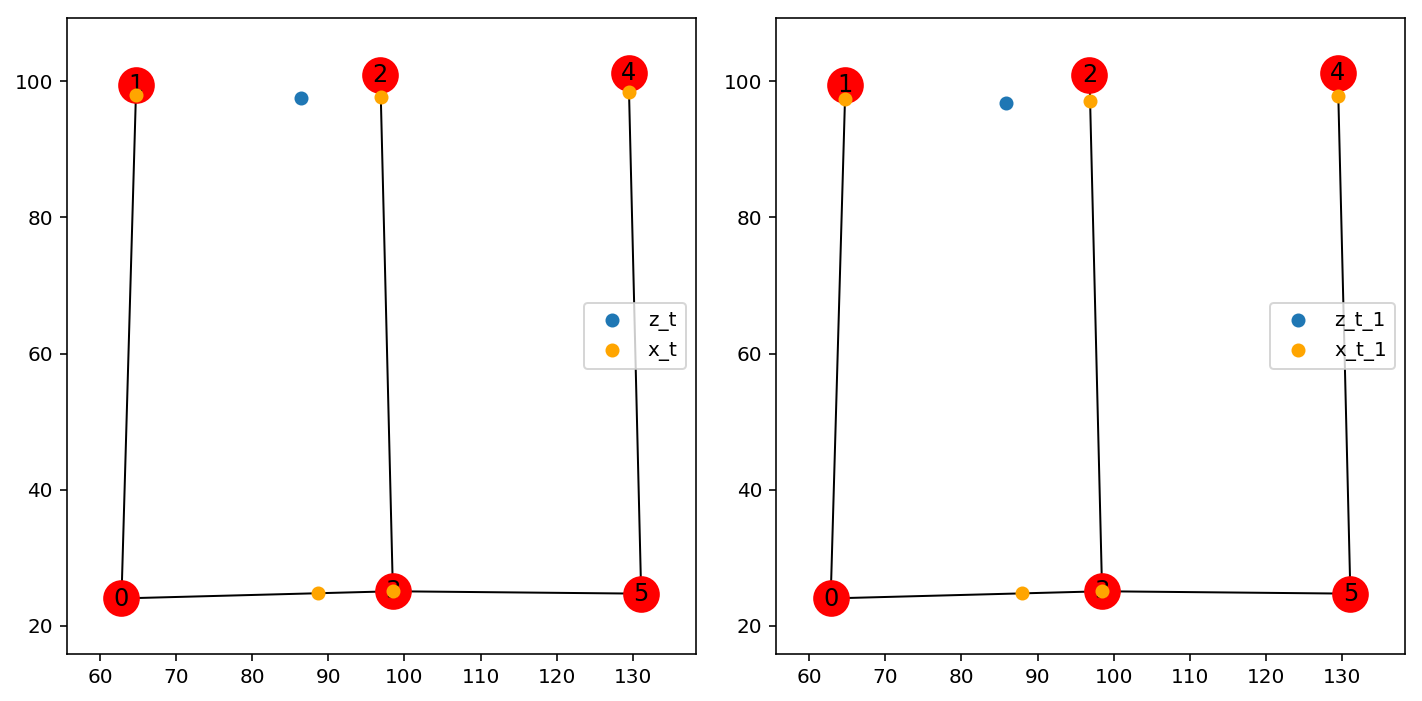

In [593]:
xy = position_info.loc[:, ['x_position', 'y_position']].values
projected_points = project_point2(track_segments, xy)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ind_t = 2
ind_t_1 = 3

axes[0].scatter(xy[ind_t][0], xy[ind_t][1], label='z_t')
nx.draw_networkx(G, nx.get_node_attributes(G, 'pos'), ax=axes[0])
axes[0].scatter(projected_points[ind_t][:, 0],
                projected_points[ind_t][:, 1],
                color='orange', label='x_t' , zorder=1000)
axes[0].legend()
axes[1].scatter(xy[ind_t_1][0], xy[ind_t_1][1], label='z_t_1')
nx.draw_networkx(G, nx.get_node_attributes(G, 'pos'), ax=axes[1])
axes[1].scatter(projected_points[ind_t_1][:, 0],
                projected_points[ind_t_1][:, 1],
                color='orange', label='x_t_1', zorder=1000)
axes[1].legend()

plt.tight_layout()

In [781]:
from scipy.stats import norm

def route_distances(segments, points, G, edges):
    projected_points = project_point2(segments, points)
    distances = np.stack(
        [route_distance(p_t, p_t_1, G, edges)
         for p_t, p_t_1 in zip(projected_points[1:], projected_points[:-1])])
    return np.concatenate((np.full((1, *distances.shape[1:]), np.nan), distances))


def emission_prob(segments, points, sigma=10):
    return (np.exp(
            -0.5 * (find_projected_point_distance(segments, points) / sigma) ** 2) /
            (np.sqrt(2 * np.pi) * sigma))

# A empirical distribution
def transition_prob(points, segments, G, edges, beta=100):
    route_point_diff = np.abs(route_distances(segments, points, G, edges) -
              point_distance(points)[:, np.newaxis, np.newaxis])
    e = np.exp(-route_point_diff / beta) / beta
    return e / e.sum(axis=2, keepdims=True)

In [19]:
def viterbi(initial_conditions, state_transition, likelihood):
    n_time, n_states = likelihood.shape
    posterior = np.zeros((n_time, n_states))
    max_state_ind = np.zeros((n_time, n_states), dtype=np.int)

    #initialization
    posterior[0] = initial_conditions * likelihood[0]

    #recursion
    for time_ind in range(1, n_time):
        prior = posterior[time_ind - 1] * state_transition[time_ind].T
        max_state_ind[time_ind] = prior.argmax(axis=1)
        posterior[time_ind] = prior[np.arange(n_states), max_state_ind[time_ind]] * likelihood[time_ind]

    #termination
    Q = np.zeros((n_time,), dtype=np.int)
    Q[n_time - 1] = np.argmax(posterior[n_time - 1])
    Pv = posterior[n_time - 1, Q[n_time - 1]]

    #path back-tracking
    for time_ind in reversed(range(n_time - 1)):
        Q[time_ind] = max_state_ind[time_ind + 1, Q[time_ind + 1]]

    return Q

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


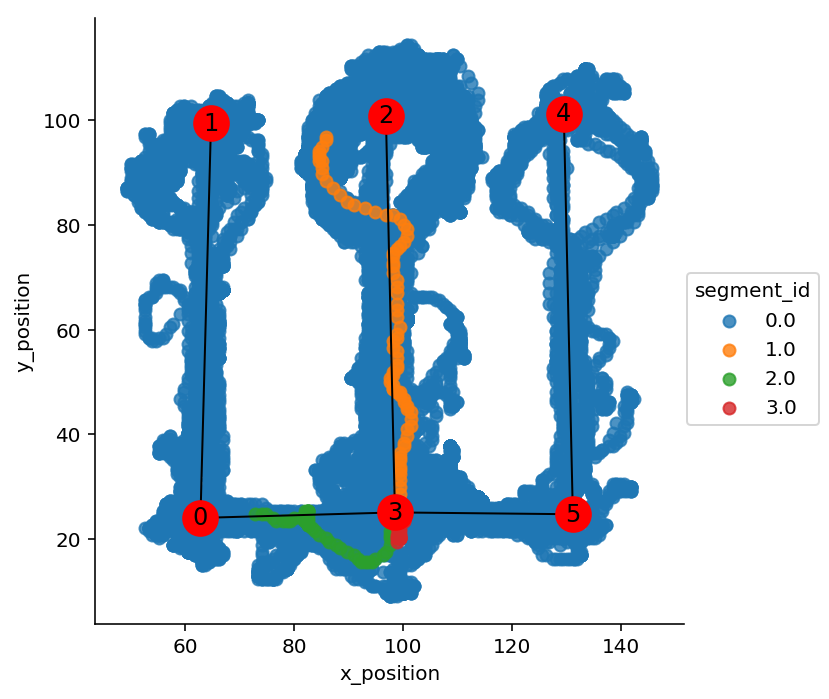

In [972]:
initial_conditions = np.ones(5,)
state_transition = transition_prob(points, segments, G, edges, beta=1E2)
likelihood = emission_prob(segments, points, sigma=5)

v = viterbi(initial_conditions, t[3:], likelihood[3:])
v = np.concatenate(([np.nan, np.nan, np.nan], v))
naive_position_info3 = position_info.copy()
naive_position_info3['segment_id'] = v
sns.lmplot('x_position', 'y_position', data=naive_position_info3, hue='segment_id', fit_reg=False)
node_pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, node_pos)

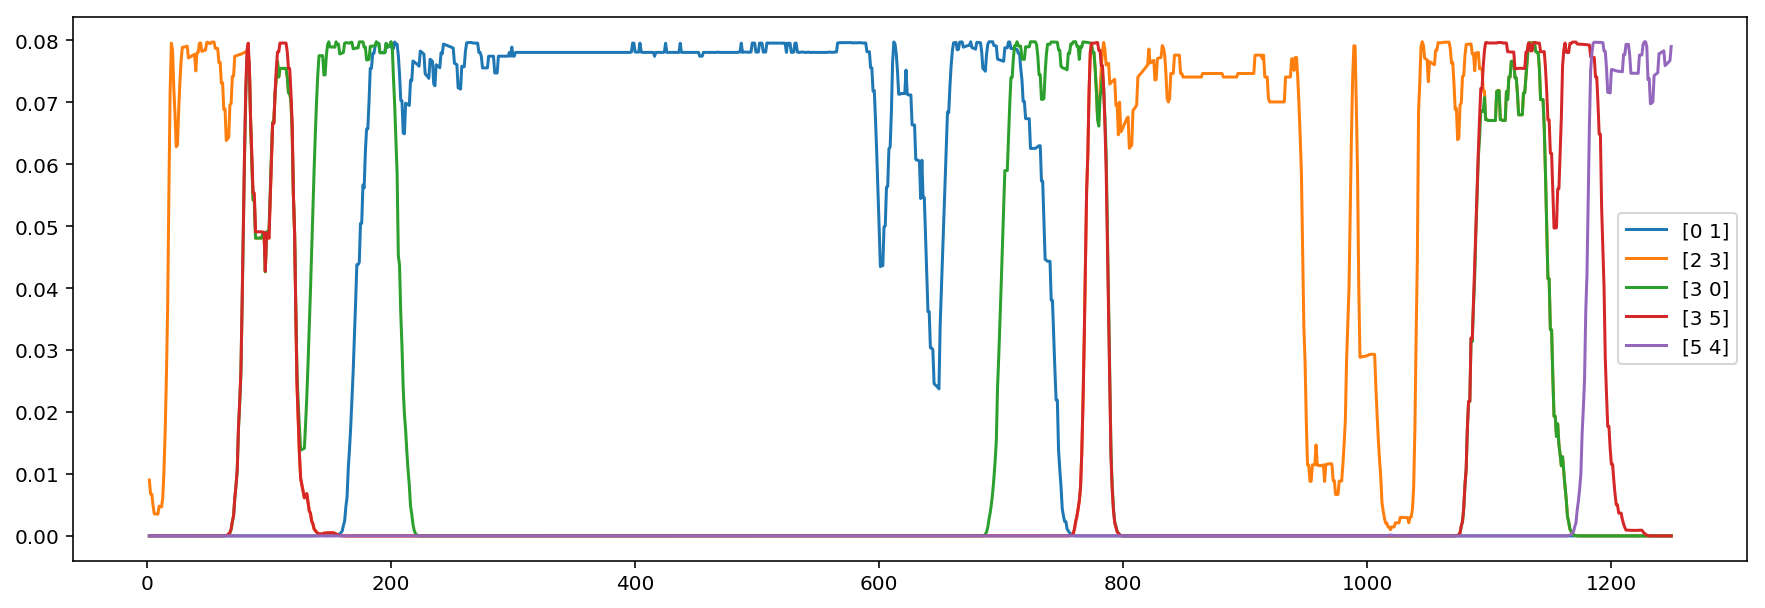

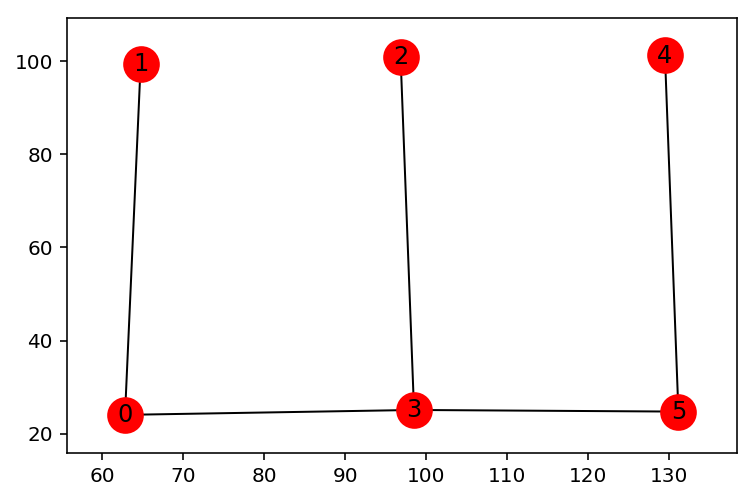

In [882]:
plt.figure(figsize=(15, 5)); plt.plot(likelihood[:1250]); plt.legend(edges)

plt.figure()
node_pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, node_pos)

In [998]:
likelihood = likelihood[3:]
state_transition = state_transition[3:]

n_time, n_states = likelihood.shape
posterior = np.zeros((n_time, n_states))
max_state_ind = np.zeros((n_time, n_states), dtype=np.int)

#initialization
posterior[0] = initial_conditions * likelihood[0]

#recursion
for time_ind in range(1, n_time):
    prior = posterior[time_ind - 1] * state_transition[time_ind].T
    max_state_ind[time_ind] = prior.argmax(axis=1)
    posterior[time_ind] = prior[np.arange(n_states), max_state_ind[time_ind]] * likelihood[time_ind]

#termination
Q = np.zeros((n_time,), dtype=np.int)
Q[n_time - 1] = np.argmax(posterior[n_time - 1])
Pv = posterior[n_time - 1, Q[n_time - 1]]

#path back-tracking
for time_ind in reversed(range(n_time - 1)):
    Q[time_ind] = max_state_ind[time_ind + 1, Q[time_ind + 1]]

In [783]:
def viterbi(initial_conditions, state_transition, likelihood):
    n_time, n_states = likelihood.shape
    posterior = np.zeros((n_time, n_states))
    max_state_ind = np.zeros((n_time, n_states), dtype=np.int)

    #initialization
    posterior[0] = initial_conditions * likelihood[0]

    #recursion
    for time_ind in range(1, n_time):
        prior = posterior[time_ind - 1] * state_transition[time_ind]
        max_state_ind[time_ind] = prior.argmax(axis=1)
        posterior[time_ind] = prior[np.arange(n_states), max_state_ind[time_ind]] * likelihood[time_ind]

    #termination
    Q = np.zeros((n_time,), dtype=np.int)
    Q[n_time - 1] = np.argmax(posterior[n_time - 1])
    Pv = posterior[n_time - 1, Q[n_time - 1]]

    #path back-tracking
    for time_ind in reversed(range(n_time - 1)):
        Q[time_ind] = max_state_ind[time_ind + 1, Q[time_ind + 1]]

    return Q

def viterbi_log(initial_conditions, state_transition, likelihood):
    
    is_nan = np.any(np.isnan(likelihood), axis=1)
    likelihood = likelihood.copy()[~is_nan]
    state_transition = state_transition.copy()[~is_nan]
    
    n_time, n_states = likelihood.shape
    posterior = np.zeros((n_time, n_states))
    max_state_ind = np.zeros((n_time, n_states), dtype=np.int)
    
    #initialization
    posterior[0] = np.log(initial_conditions) + np.log(likelihood[0])

    #recursion
    for time_ind in range(1, n_time):
        prior = posterior[time_ind - 1] + np.log(state_transition[time_ind])
        max_state_ind[time_ind] = prior.argmax(axis=1)
        posterior[time_ind] = prior[np.arange(n_states), max_state_ind[time_ind]] + np.log(likelihood[time_ind])

    #termination
    most_probable_state_ind = np.zeros((n_time,), dtype=np.int)
    most_probable_state_ind[n_time - 1] = np.argmax(posterior[n_time - 1])
#     Pv = posterior[n_time - 1, most_probable_state_ind[n_time - 1]]

    #path back-tracking
    for time_ind in reversed(range(n_time - 1)):
        most_probable_state_ind[time_ind] = max_state_ind[
            time_ind + 1, most_probable_state_ind[time_ind + 1]]
    
    most_probable_state_ind_with_nan = np.full((is_nan.size,), np.nan)
    most_probable_state_ind_with_nan[~is_nan] = most_probable_state_ind
    return most_probable_state_ind_with_nan
    

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


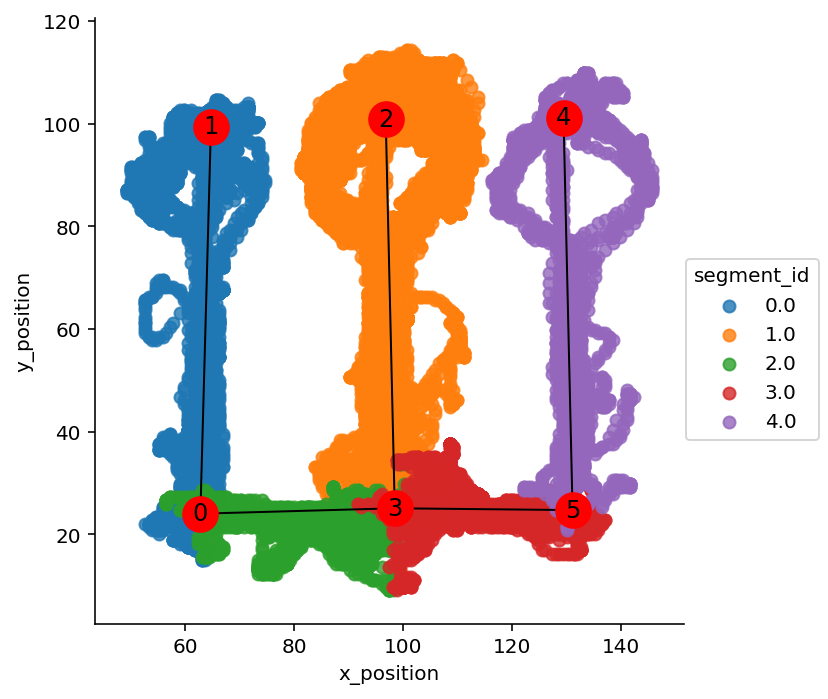

In [851]:

initial_conditions = np.ones(5,)
state_transition = transition_prob(xy, track_segments, G, edges, beta=1E-1)
likelihood = emission_prob(track_segments, xy, sigma=10)

v = viterbi_log(initial_conditions, state_transition, likelihood)
naive_position_info3 = position_info.copy()
naive_position_info3['segment_id'] = v
sns.lmplot('x_position', 'y_position', data=naive_position_info3, hue='segment_id', fit_reg=False)
node_pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, node_pos)

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


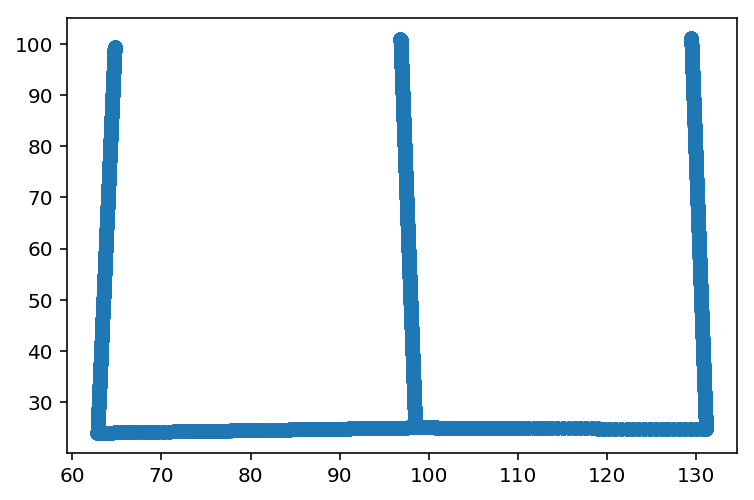

In [852]:
projected_points = project_point2(track_segments, xy)
is_nan = np.isnan(v)
v[is_nan] = 0
p = projected_points[(np.arange(projected_points.shape[0]), v.astype(int))]
e = edges[v.astype(int)]
plt.scatter(p[:, 0], p[:, 1])

In [853]:
linear_distance = []

for p0, e0 in zip(p, e):
    G1 = G.copy()
    node1, node2 = e0
    G1.add_path([node1, 'c0', node2])
    G1.remove_edge(node1, node2)
    G1.nodes['c0']['pos'] = tuple(p0)

    ## calculate distance
    for edge in G1.edges(data=True):
        G1.edges[edge[:2]]['distance'] = np.linalg.norm(
            G1.node[edge[0]]['pos'] -
            np.array(G1.node[edge[1]]['pos']))

    linear_distance.append(nx.shortest_path_length(G1, source='c0', target=2, weight='distance'))
    
linear_distance = np.array(linear_distance)

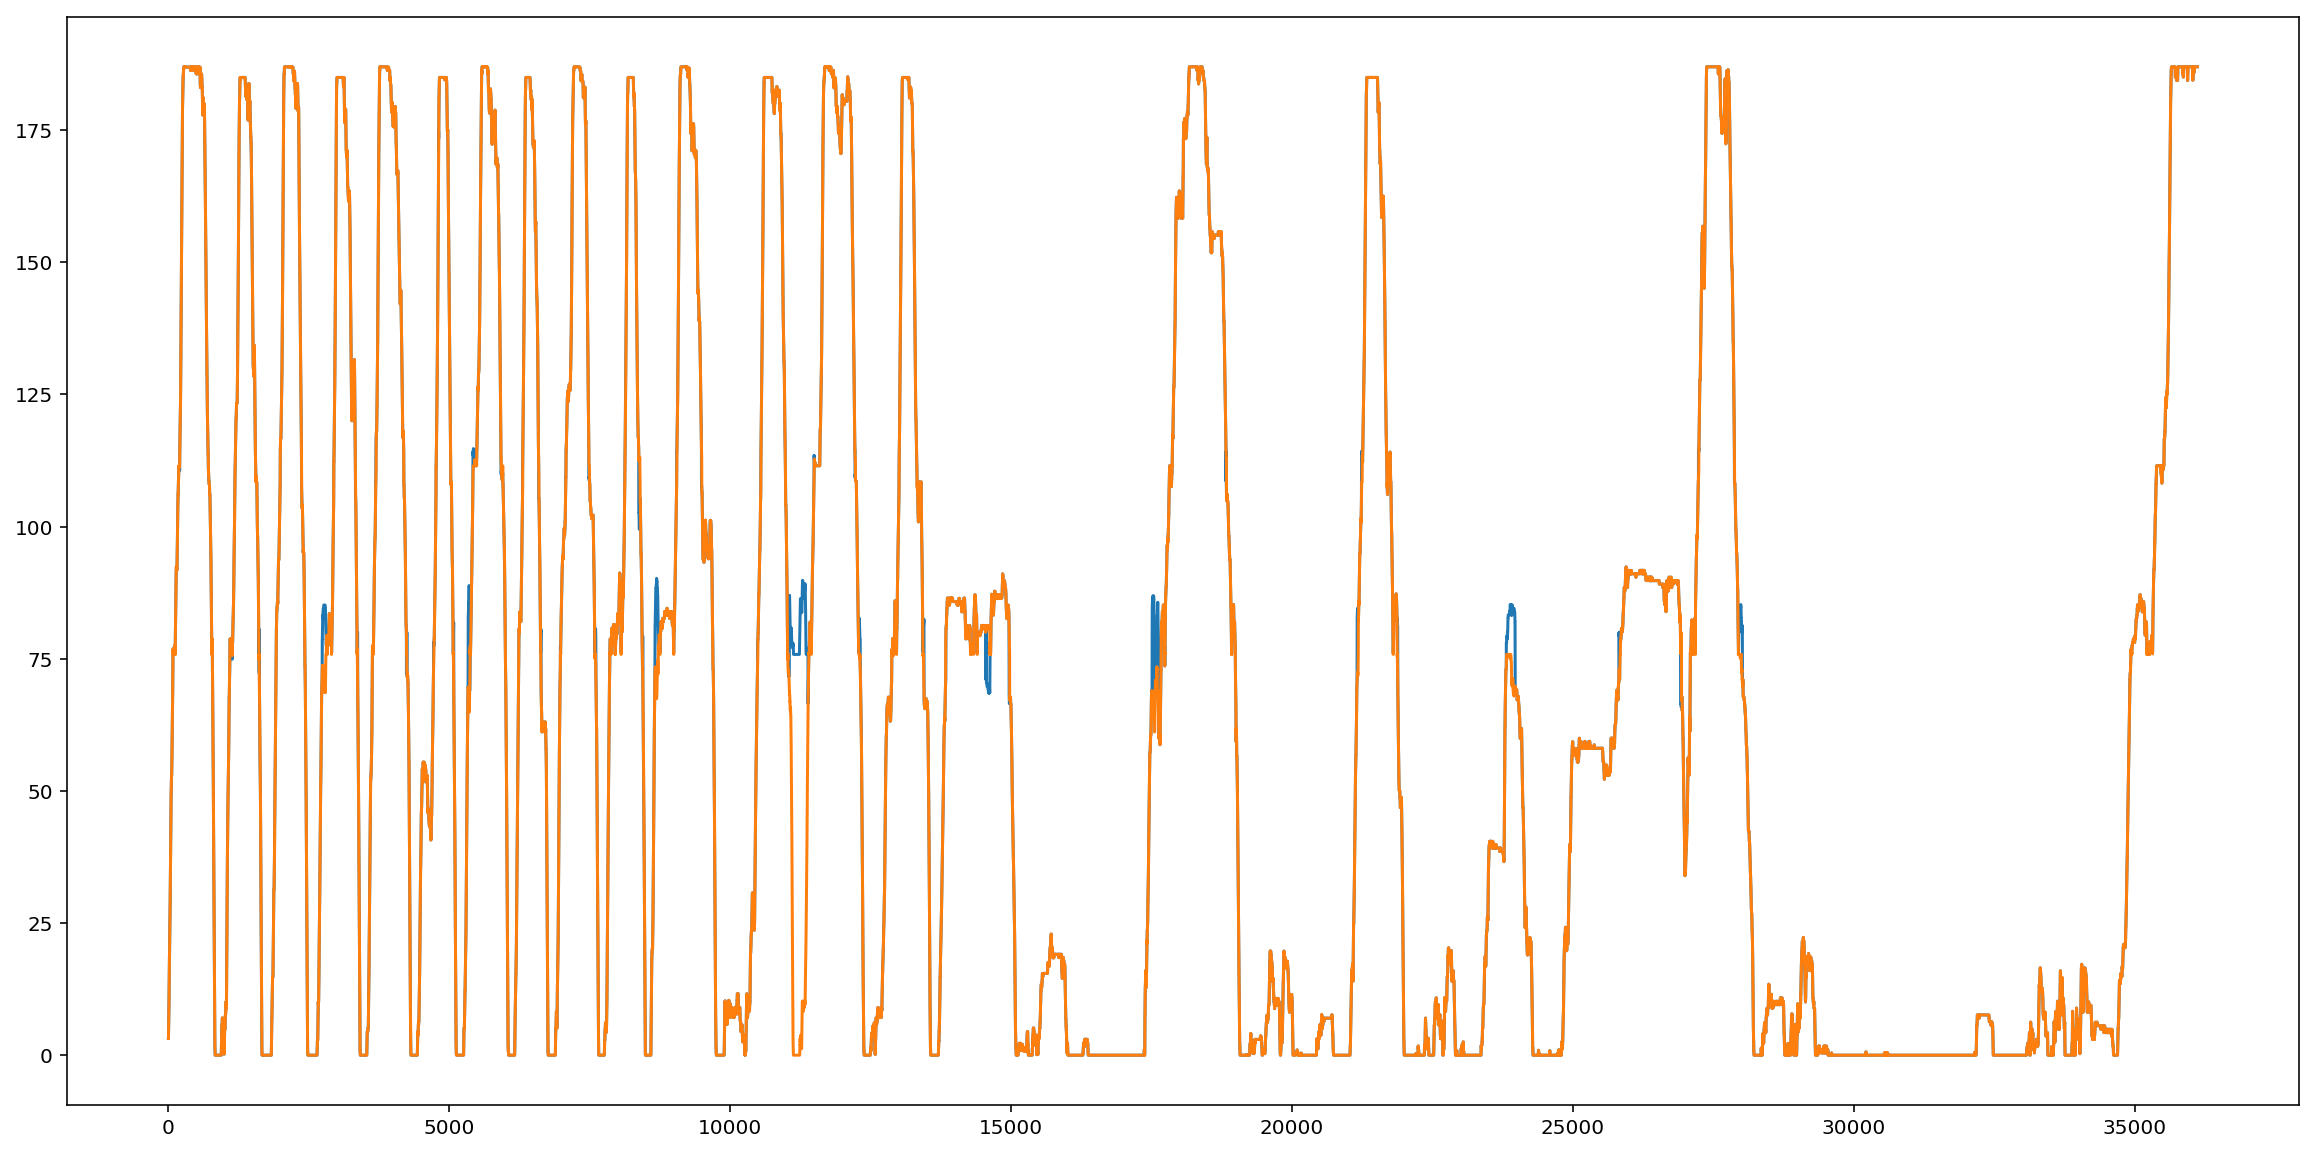

In [854]:
from loren_frank_data_processing.position import get_linear_position_structure
linear_position = get_linear_position_structure(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10));
plt.plot(linear_position.linear_distance.values)
plt.plot(linear_distance)

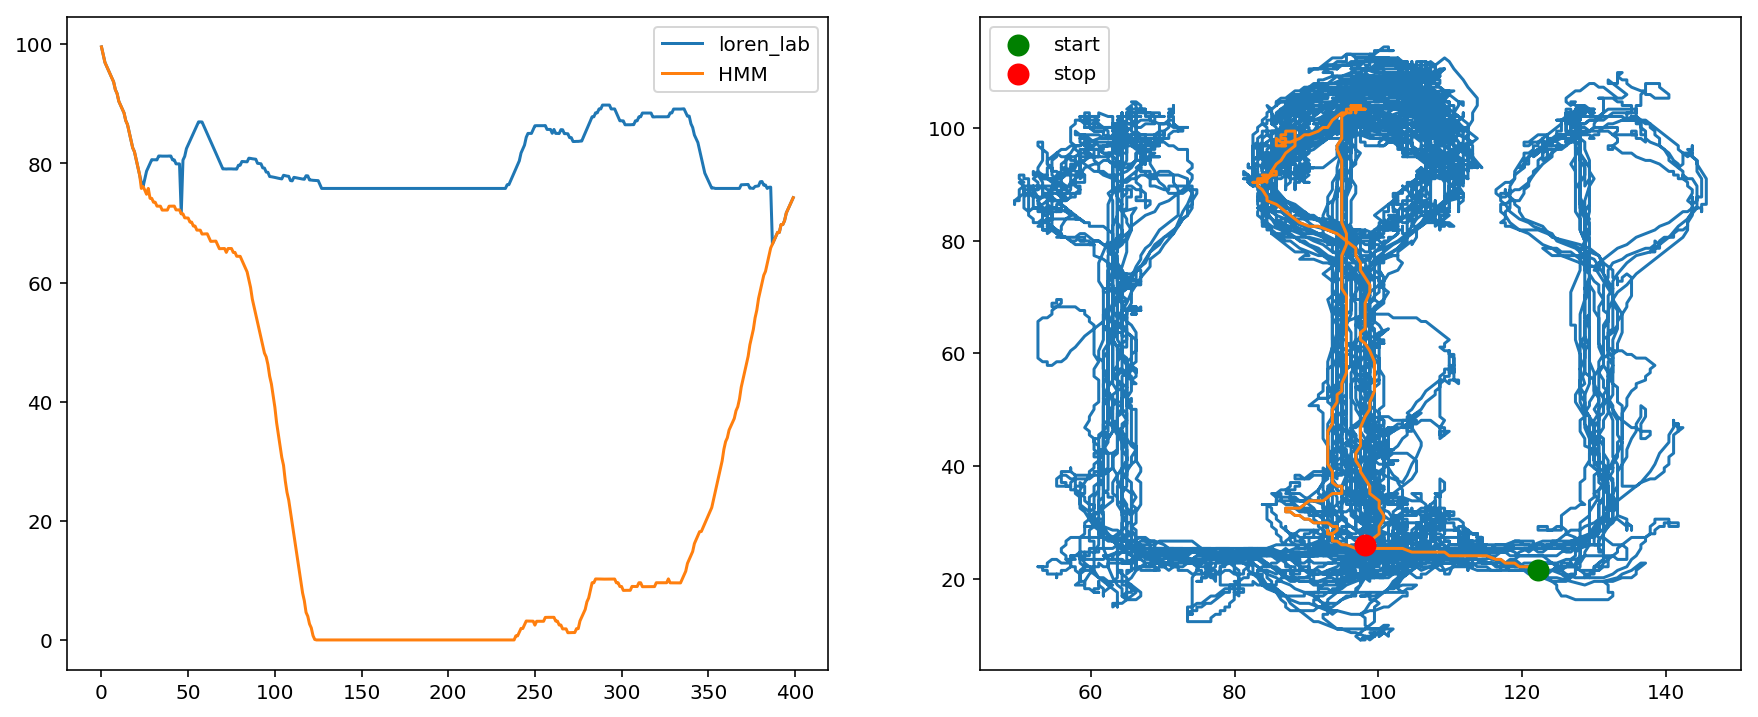

In [855]:
start, stop = 11000, 11400
ind = slice(start, stop)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(linear_position.linear_distance.values[ind], label='loren_lab')
axes[0].plot(linear_distance[ind], label='HMM')
axes[0].legend()

axes[1].plot(xy[:, 0], xy[:, 1])
axes[1].plot(xy[ind, 0], xy[ind, 1])
axes[1].scatter(xy[start, 0], xy[start, 1], color='green', zorder=1000, s=100, label='start')
axes[1].scatter(xy[stop, 0], xy[stop, 1], color='red', zorder=1000, s=100, label='stop')
axes[1].legend();

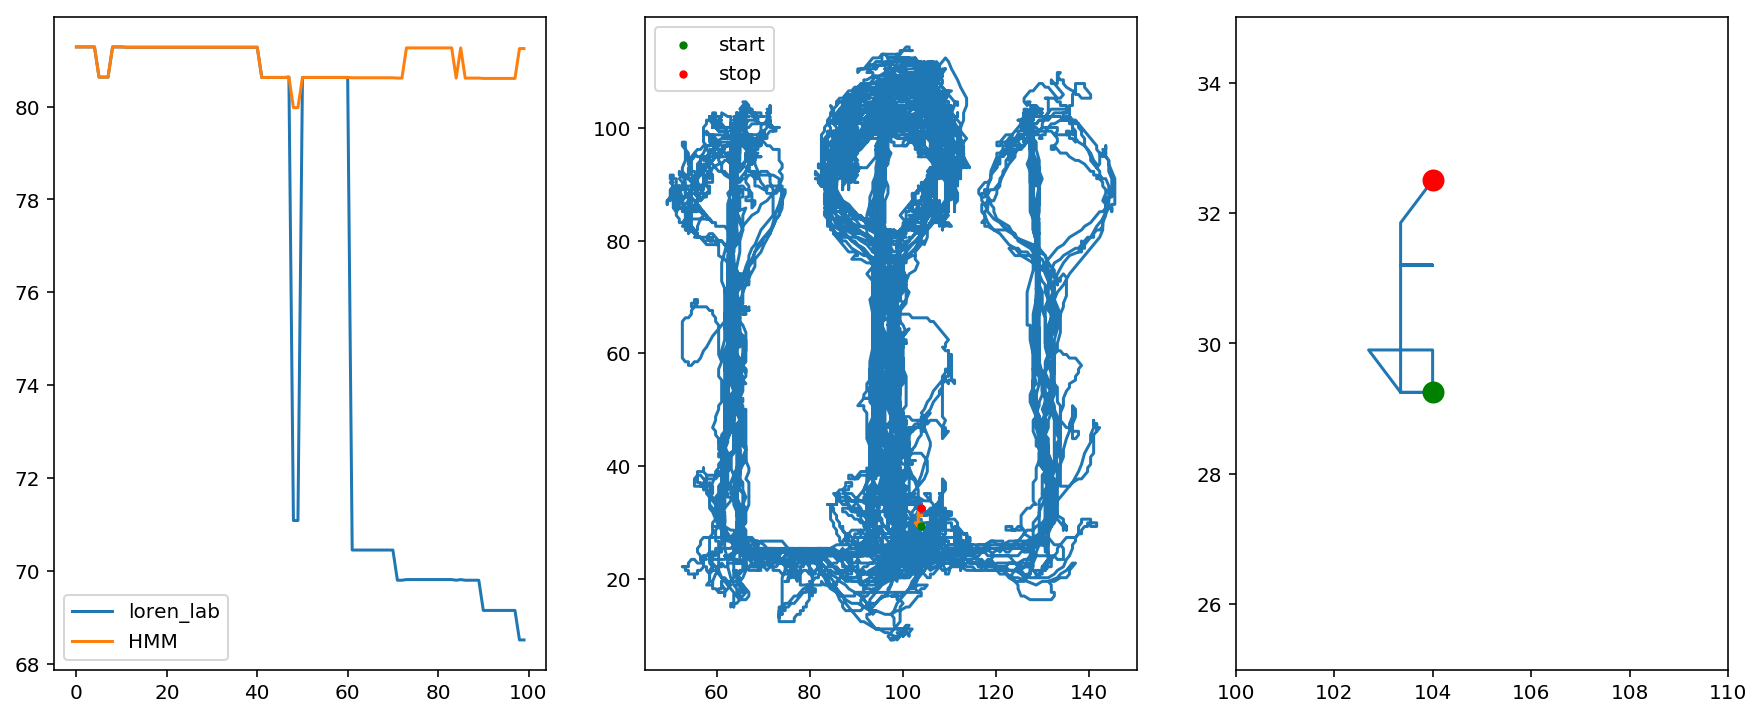

In [856]:
start, stop = 14500, 14600
ind = slice(start, stop)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].plot(linear_position.linear_distance.values[ind], label='loren_lab')
axes[0].plot(linear_distance[ind], label='HMM')
axes[0].legend()

axes[1].plot(xy[:, 0], xy[:, 1])
axes[1].plot(xy[ind, 0], xy[ind, 1])
axes[1].scatter(xy[start, 0], xy[start, 1], color='green', zorder=1000, s=10, label='start')
axes[1].scatter(xy[stop, 0], xy[stop, 1], color='red', zorder=1000, s=10, label='stop')
axes[1].legend();

axes[2].plot(xy[ind, 0], xy[ind, 1])
axes[2].scatter(xy[start, 0], xy[start, 1], color='green', zorder=1000, s=100)
axes[2].scatter(xy[stop, 0], xy[stop, 1], color='red', zorder=1000, s=100)
axes[2].set_xlim((100, 110))
axes[2].set_ylim((25, 35));

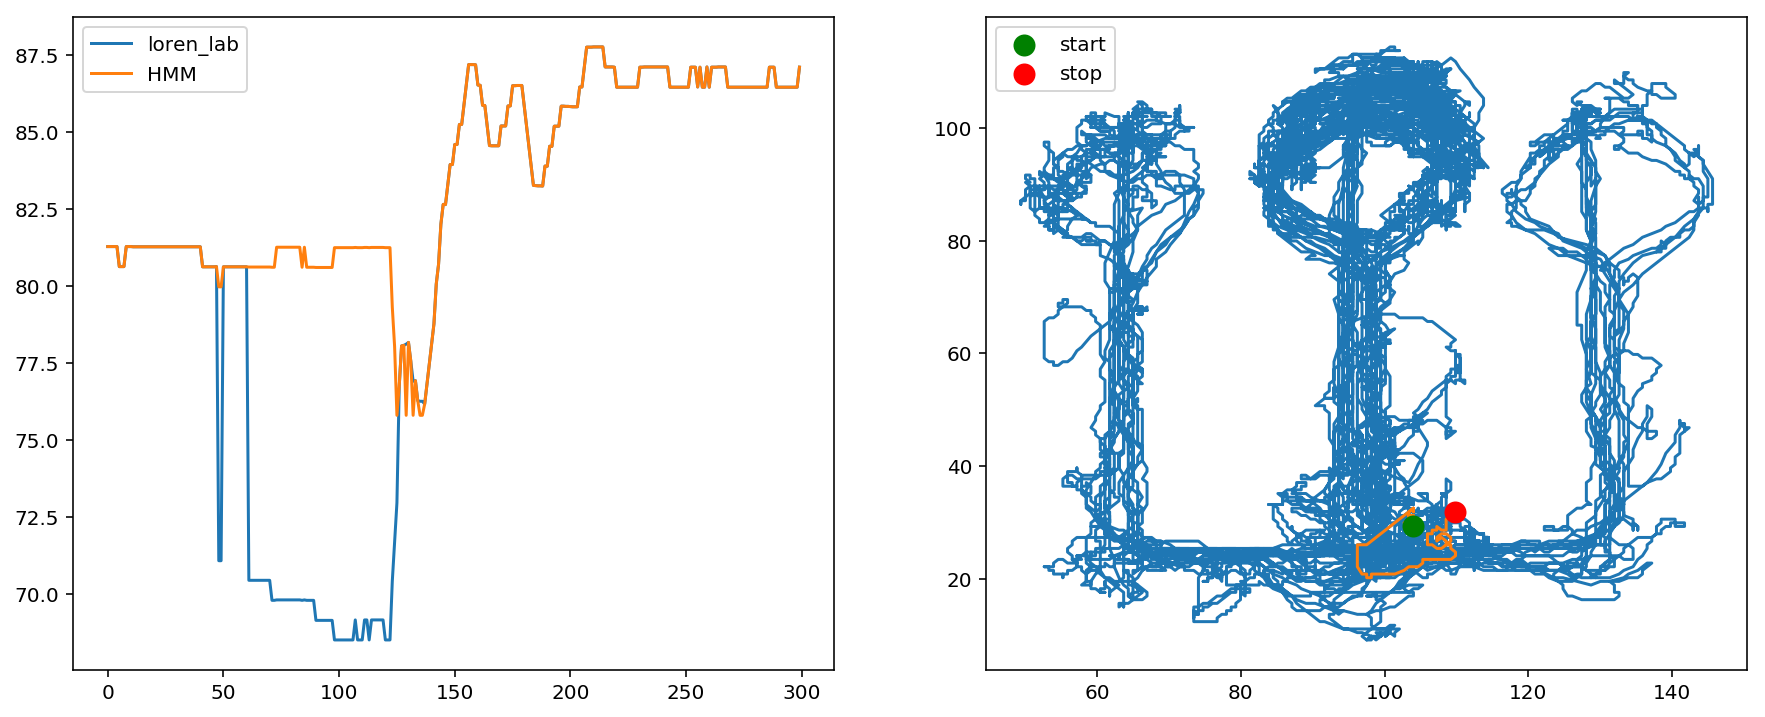

In [857]:
start, stop = 14500, 14800
ind = slice(start, stop)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(linear_position.linear_distance.values[ind], label='loren_lab')
axes[0].plot(linear_distance[ind], label='HMM')
axes[0].legend()

axes[1].plot(xy[:, 0], xy[:, 1])
axes[1].plot(xy[ind, 0], xy[ind, 1])
axes[1].scatter(xy[start, 0], xy[start, 1], color='green', zorder=1000, s=100, label='start')
axes[1].scatter(xy[stop, 0], xy[stop, 1], color='red', zorder=1000, s=100, label='stop')
axes[1].legend();

(25, 35)

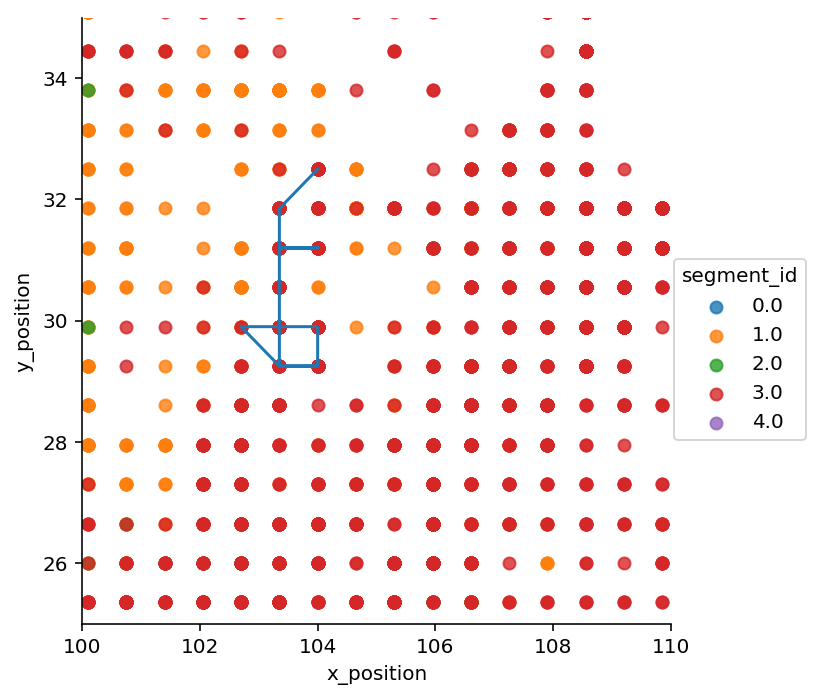

In [858]:
start, stop = 14500, 14600
ind = slice(start, stop)
sns.lmplot('x_position', 'y_position', data=naive_position_info3, hue='segment_id', fit_reg=False)
plt.plot(xy[ind, 0], xy[ind, 1])
plt.xlim((100, 110))
plt.ylim((25, 35))

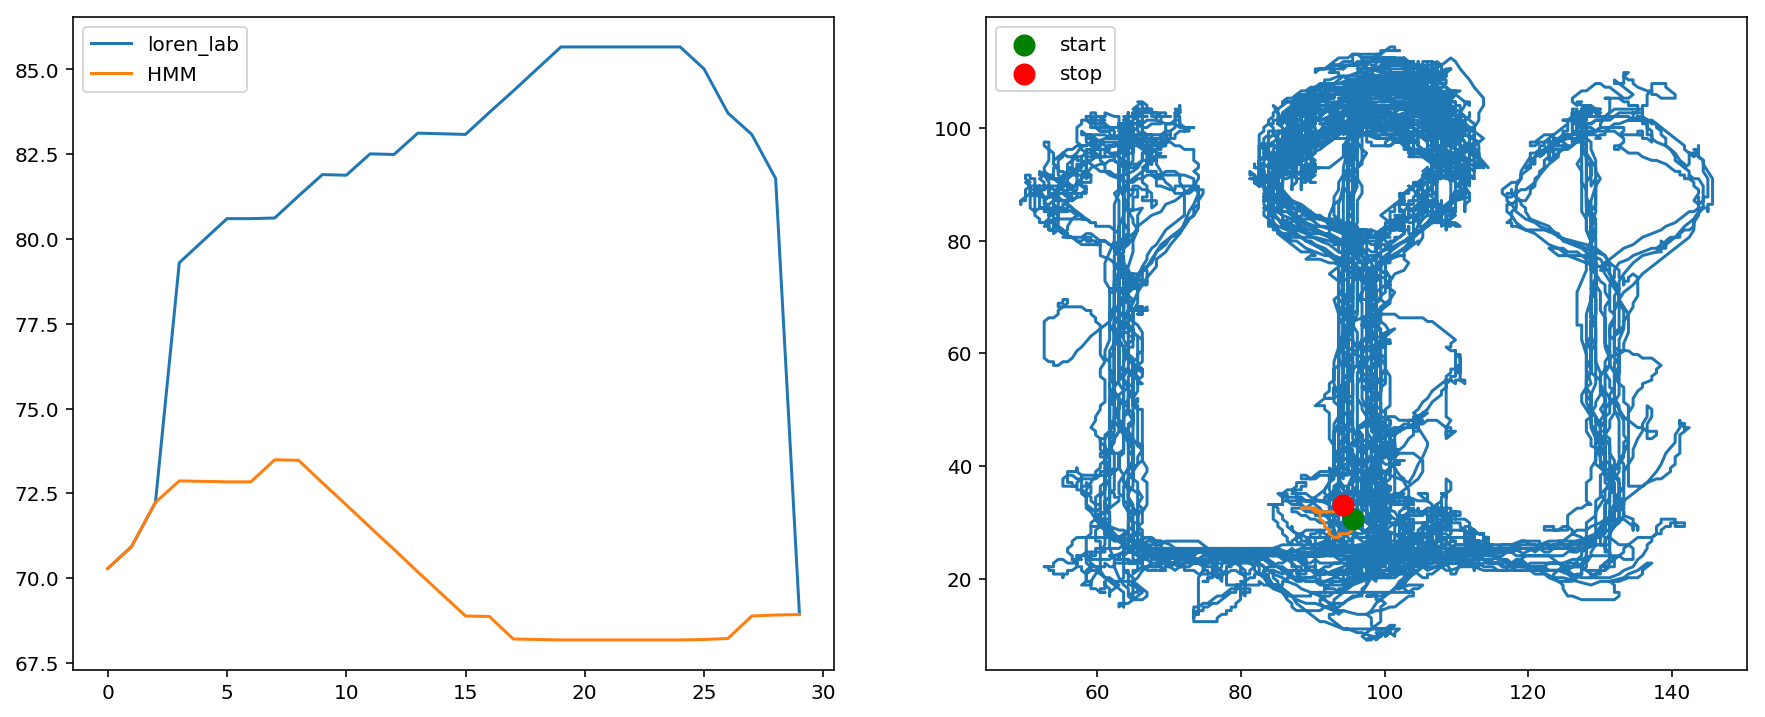

In [859]:
start, stop = 17590, 17620
ind = slice(start, stop)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(linear_position.linear_distance.values[ind], label='loren_lab')
axes[0].plot(linear_distance[ind], label='HMM')
axes[0].legend()

axes[1].plot(xy[:, 0], xy[:, 1])
axes[1].plot(xy[ind, 0], xy[ind, 1])
axes[1].scatter(xy[start, 0], xy[start, 1], color='green', zorder=1000, s=100, label='start')
axes[1].scatter(xy[stop, 0], xy[stop, 1], color='red', zorder=1000, s=100, label='stop')
axes[1].legend();

(25, 40)

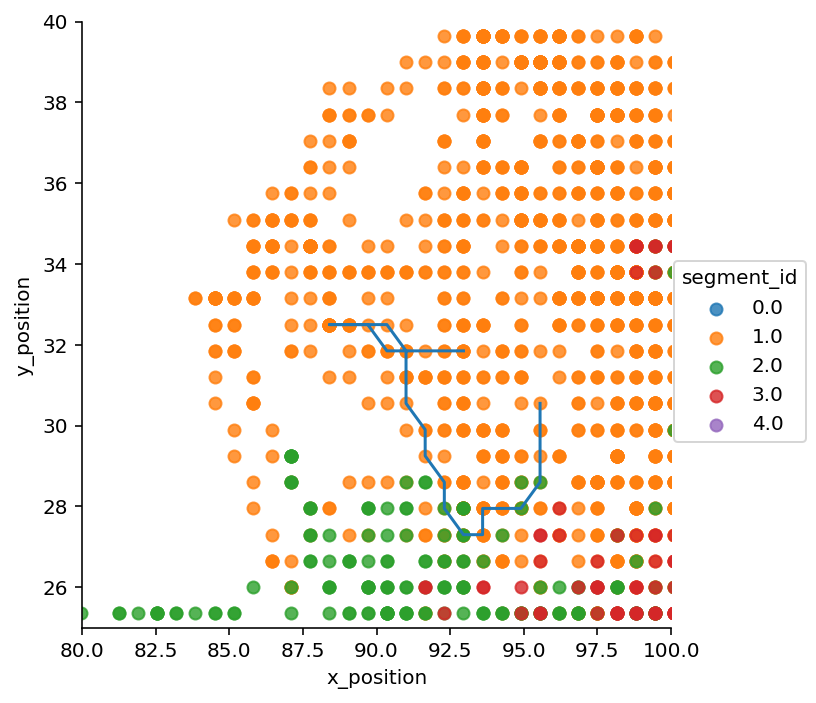

In [860]:
start, stop = 17590, 17620
ind = slice(start, stop)
sns.lmplot('x_position', 'y_position', data=naive_position_info3, hue='segment_id', fit_reg=False)
plt.plot(xy[ind, 0], xy[ind, 1])
plt.xlim((80, 100))
plt.ylim((25, 40))

(25, 40)

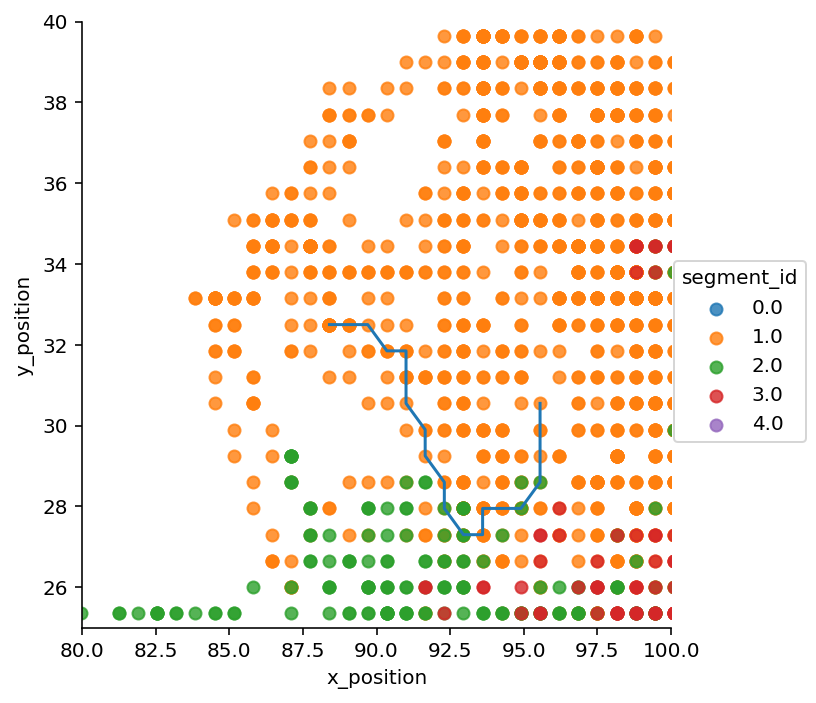

In [861]:
start, stop = 17590, 17610
ind = slice(start, stop)
sns.lmplot('x_position', 'y_position', data=naive_position_info3, hue='segment_id', fit_reg=False)
plt.plot(xy[ind, 0], xy[ind, 1])
plt.xlim((80, 100))
plt.ylim((25, 40))

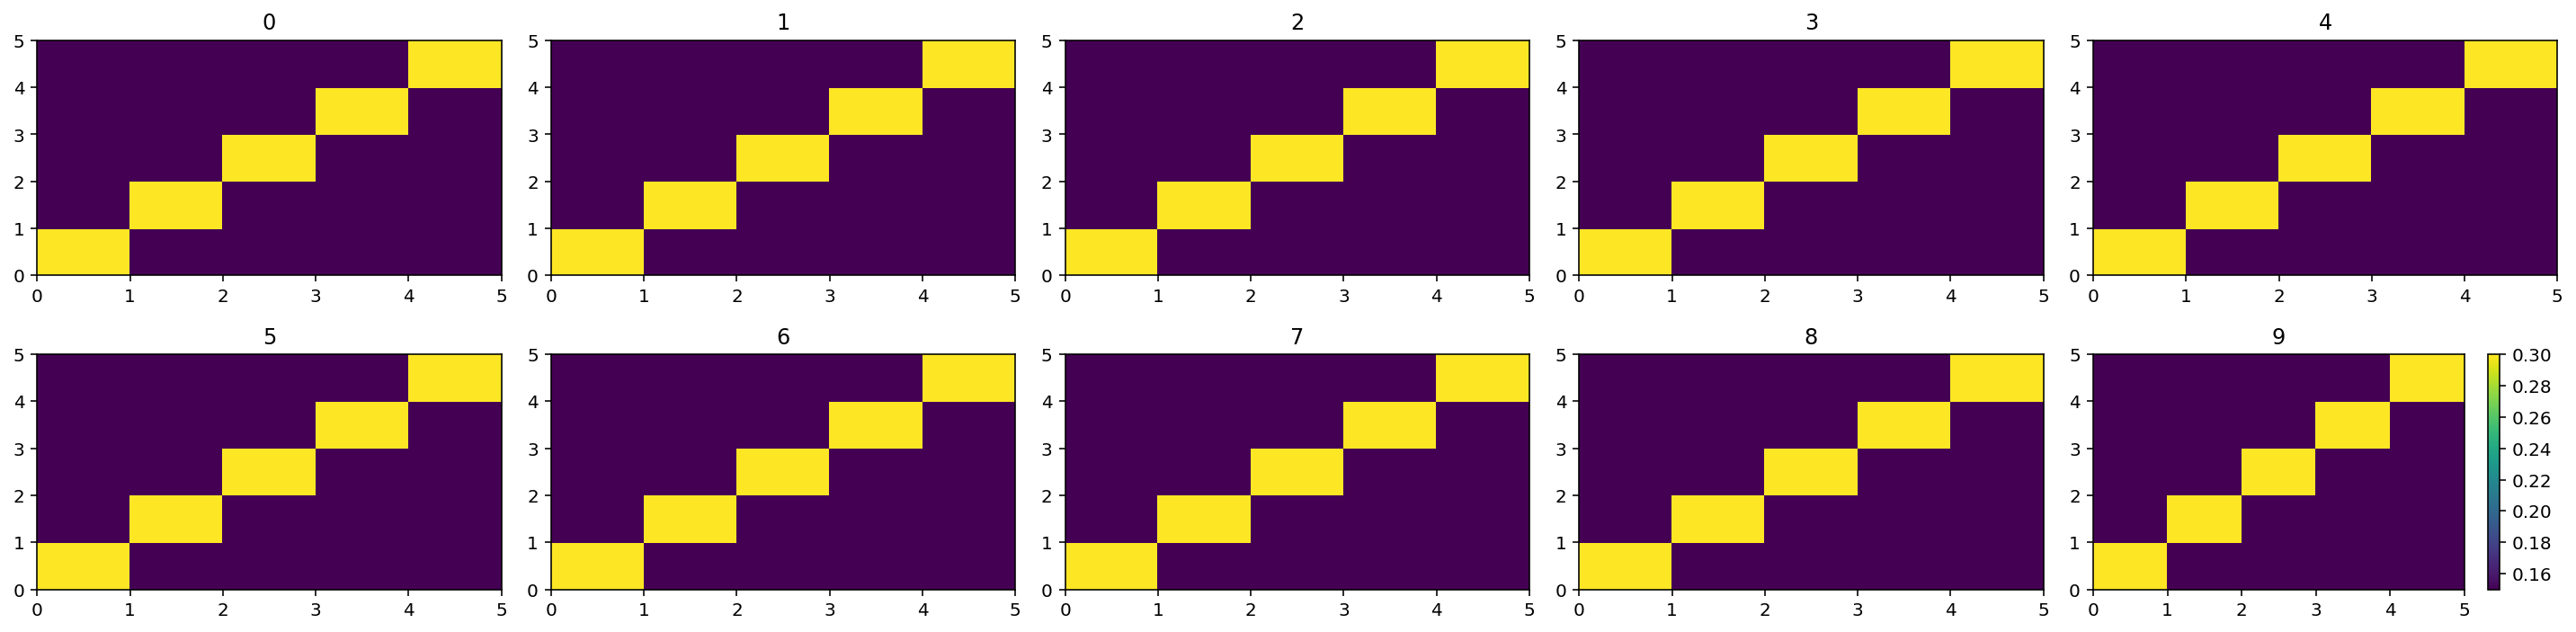

In [862]:
start, stop = 17590, 17600
ind = slice(start, stop)
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
for i, (ax, st) in enumerate(zip(axes.flat, state_transition[ind])):
    m = ax.pcolor(st, vmin=0.15, vmax=0.30)
    ax.set_title(i)
plt.tight_layout()
plt.colorbar(m)

(25, 40)

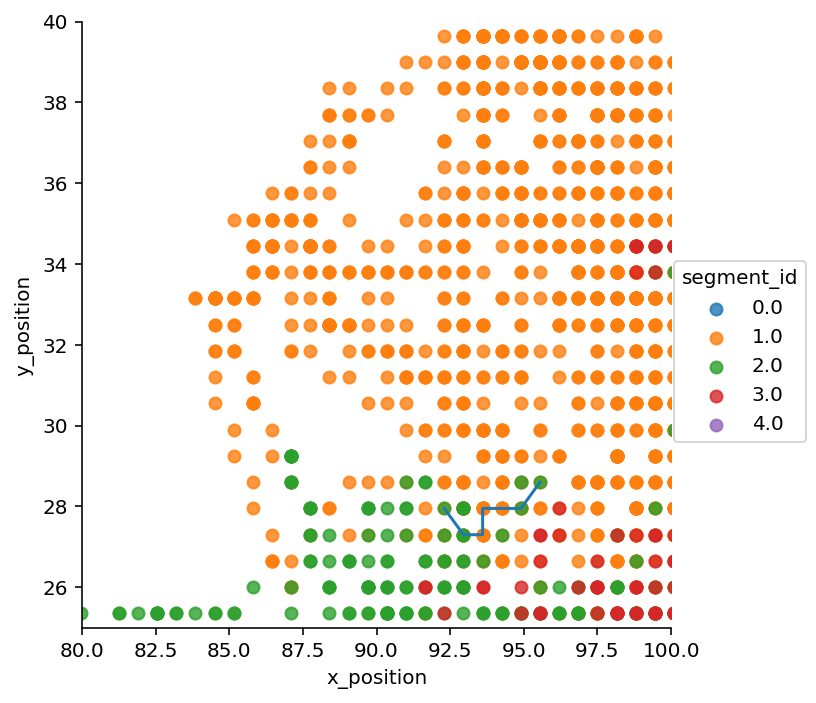

In [863]:
start, stop = 17592, 17600
ind = slice(start, stop)
sns.lmplot('x_position', 'y_position', data=naive_position_info3, hue='segment_id', fit_reg=False)
plt.plot(xy[ind, 0], xy[ind, 1])
plt.xlim((80, 100))
plt.ylim((25, 40))